In [2]:
import tkinter
import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
# Slice origin point
center_point = torch.tensor([[5.0],[5.0]])

origin = torch.tensor([[0.0],[0.0]])

# Slices must be longer than 500^.5. Slices creater by rotating starter
slice_starter = torch.tensor([[30.0], [0.0]])

# Creates a rotation matrix from a given theta
rotate_mat = lambda theta : torch.cat((torch.cos(theta).view(1), -torch.sin(theta).view(1), torch.sin(theta).view(1), torch.cos(theta).view(1))).view((2,2))
# Creates slice vector
get_slice = lambda theta : rotate_mat(theta) @ slice_starter + center_point

upper_left  = torch.tensor([[0.0],[10.0]])
upper_right = torch.tensor([[20.0],[10.0]])
lower_left  = torch.tensor([[0.0],[0.0]])
lower_right = torch.tensor([[20.0],[0.0]])

In [4]:
def cross_2d(vec1, vec2):
    return vec1[0,0] * vec2[1,0] - vec1[1,0] * vec2[0,0]


def find_slice_intersection(slice, center_point, vec2, shift2):
    vec1 = (slice - center_point).T.view(2,1)
    vec2 = vec2.T.view(2,1)
    shift1 = center_point.T.view(2,1)
    shift2 = shift2.T.view(2,1)

    t = cross_2d((shift2 - shift1), vec2) / cross_2d(vec1, vec2)
    u = cross_2d((shift2 - shift1), vec1) / cross_2d(vec1, vec2)

    if cross_2d(vec1, vec2).abs() < 1e-10:
        # The lines are parallel
        return False
    elif t > 0 and t < 1 and u > 0 and u < 1:
        # The lines intersect
        return (t*vec1 + shift1).T
    else:
        # The lines do not intersect
        return False

    
def get_intersection_point(slice, center_point):
    intersection_top = find_slice_intersection(slice, center_point, lower_right, upper_left)
    intersection_left = find_slice_intersection(slice, center_point, upper_left, origin)
    intersection_right = find_slice_intersection(slice, center_point, upper_left, lower_right)
    intersection_bottom = find_slice_intersection(slice, center_point, lower_right, origin)

    # Hopefully this doen't break
    if intersection_top is not False:
        return intersection_top
    elif intersection_left is not False:
        return intersection_left
    elif intersection_right is not False:
        return intersection_right
    elif intersection_bottom is not False: 
        return intersection_bottom
    else:
        return False

In [27]:
def draw_cake(center_point, theta1, theta2, theta3):
    slice1 = get_slice(theta1.detach())
    slice2 = get_slice(theta2.detach())
    slice3 = get_slice(theta3.detach())

    # Scaling and shifting is done for visualization purposes. tkiniter has an inverse y axis
    scale_factor = torch.tensor([[1.0,0.0],[0.0,-1.0]])
    scale_factor *= 5.0
    shift = torch.tensor([[100.0], [100.0]])

    # Transforms points to graphics space
    graphics_transform = lambda point : scale_factor @ point + shift

    # Transform all points and draw lines
    center_point_g = graphics_transform(center_point)

    slice1_g = graphics_transform(slice1)
    slice2_g = graphics_transform(slice2)
    slice3_g = graphics_transform(slice3)

    upper_left_g = graphics_transform(upper_left)
    upper_right_g = graphics_transform(upper_right)
    lower_left_g = graphics_transform(lower_left)
    lower_right_g = graphics_transform(lower_right)

    window = tkinter.Tk()
    canva = tkinter.Canvas(window)

    line = canva.create_line(*center_point_g.T.tolist()[0], *slice1_g.T.tolist()[0])
    line = canva.create_line(*center_point_g.T.tolist()[0], *slice2_g.T.tolist()[0])
    line = canva.create_line(*center_point_g.T.tolist()[0], *slice3_g.T.tolist()[0])

    line = canva.create_line(*upper_left_g.T.tolist()[0], *upper_right_g.T.tolist()[0])
    line = canva.create_line(*upper_left_g.T.tolist()[0], *lower_left_g.T.tolist()[0])
    line = canva.create_line(*lower_left_g.T.tolist()[0], *lower_right_g.T.tolist()[0])
    line = canva.create_line(*lower_right_g.T.tolist()[0], *upper_right_g.T.tolist()[0])

    canva.pack()
    window.mainloop()

In [31]:
# np.random.seed(1)

theta1 = torch.tensor(np.random.uniform(0, 2 * np.pi), requires_grad=True)
theta2 = torch.tensor(np.random.uniform(0, 2 * np.pi), requires_grad=True)
theta3 = torch.tensor(np.random.uniform(0, 2 * np.pi), requires_grad=True)

slice1 = get_slice(theta1)
slice2 = get_slice(theta2)
slice3 = get_slice(theta3)

slice1_intersection = get_intersection_point(slice1, center_point)
slice2_intersection = get_intersection_point(slice2, center_point)
slice3_intersection = get_intersection_point(slice3, center_point)

# Returns the amount of distance that you would need to travel when starting at (0,0) and 
# traversing clockwise around the cake until you reach the intersection point
def get_traversal_distance(slice_intersection):
    if torch.isclose(slice_intersection[0,0], torch.tensor(0.0), rtol=1e-3, atol=1e-5):
        # Intersection is on the left side of the rectangle
        return slice_intersection[1,0]
    elif torch.isclose(slice_intersection[1,0], torch.tensor(10.0), rtol=1e-3, atol=1e-5):
        # Intersection is on the top of the rectangle
        return 10 + slice_intersection[0,0]
    elif torch.isclose(slice_intersection[0,0], torch.tensor(20.0), rtol=1e-3, atol=1e-5):
        # Intersection is on the right side of the rectangle
        return 30 + (10 - slice_intersection[1,0])
    elif torch.isclose(slice_intersection[1,0], torch.tensor(0.0), rtol=1e-3, atol=1e-5):
        # Intersection is on the bottom of the rectangle
        return 40 + (20 - slice_intersection[0,0])
    else:
        print(slice_intersection)
        print('Error: Slice intersection does not fall on side of rectangle')

def get_slice_corners(slice1_intersection, slice2_intersection, slice3_intersection):
    dists = torch.tensor([0,
                          10,
                          30,
                          40,
                          get_traversal_distance(slice1_intersection.T),
                          get_traversal_distance(slice2_intersection.T),
                          get_traversal_distance(slice3_intersection.T)])
    
    dists = torch.sort(dists)

    points = torch.cat((lower_left.T, 
                        upper_left.T,
                        upper_right.T,
                        lower_right.T,
                        slice1_intersection,
                        slice2_intersection,
                        slice3_intersection,
                        center_point.T))
    

    slice1_points_inds = torch.tensor(-1).view(1)
    slice2_points_inds = torch.tensor(-1).view(1)
    slice3_points_inds = torch.tensor(-1).view(1)
    slice_num = 1
    for index in dists.indices:
        if slice_num == 1:
            if index not in [0,1,2,3]:
                slice2_points_inds = torch.cat((index.view(1), slice2_points_inds))
                slice_num = 2
            slice1_points_inds = torch.cat((index.view(1), slice1_points_inds))
        elif slice_num == 2:
            if index not in [0,1,2,3]:
                slice3_points_inds = torch.cat((index.view(1), slice3_points_inds))
                slice_num = 3
            slice2_points_inds = torch.cat((index.view(1), slice2_points_inds))
        elif slice_num == 3:
            if index not in [0,1,2,3]:
                slice1_points_inds = torch.cat((index.view(1), slice1_points_inds))
                slice_num = 4
            slice3_points_inds = torch.cat((index.view(1), slice3_points_inds))
        else:
            slice1_points_inds = torch.cat((index.view(1), slice1_points_inds))

    slice1_points = points[slice1_points_inds]
    slice2_points = points[slice2_points_inds]
    slice3_points = points[slice3_points_inds]

    print(slice1_points)
    print(slice2_points)
    print(slice3_points)



get_slice_corners(slice1_intersection, slice2_intersection, slice3_intersection)


draw_cake(center_point, theta1, theta2, theta3)





tensor([[20.0000,  0.0000],
        [20.0000, 10.0000],
        [12.6286, 10.0000],
        [ 3.2940, 10.0000],
        [ 0.0000, 10.0000],
        [ 0.0000,  0.0000],
        [ 5.0000,  5.0000]], grad_fn=<IndexBackward0>)
tensor([[ 8.7908, 10.0000],
        [ 3.2940, 10.0000],
        [ 5.0000,  5.0000]], grad_fn=<IndexBackward0>)
tensor([[12.6286, 10.0000],
        [ 8.7908, 10.0000],
        [ 5.0000,  5.0000]], grad_fn=<IndexBackward0>)


In [4]:


def get_slice_perimeters(slice1_intersection, slice2_intersection, slice3_intersection):
    slice1_trav_dist = get_traversal_distance(slice1_intersection.T)
    slice2_trav_dist = get_traversal_distance(slice2_intersection.T)
    slice3_trav_dist = get_traversal_distance(slice3_intersection.T)

    traversal_dists = torch.sort(torch.cat((slice1_trav_dist.view(1), slice2_trav_dist.view(1), slice3_trav_dist.view(1)))).values

    perims = torch.cat(((traversal_dists[1] - traversal_dists[0]).view(1),
                       (traversal_dists[2] - traversal_dists[1]).view(1),
                       (60 - traversal_dists[2] + traversal_dists[0]).view(1)))
    
    return perims


# Returns the amount of distance that you would need to travel when starting at (0,0) and 
# traversing clockwise around the cake until you reach the intersection point
def get_traversal_distance(slice_intersection):
    if torch.isclose(slice_intersection[0,0], torch.tensor(0.0), rtol=1e-3, atol=1e-5):
        # Intersection is on the left side of the rectangle
        return slice_intersection[1,0]
    elif torch.isclose(slice_intersection[1,0], torch.tensor(10.0), rtol=1e-3, atol=1e-5):
        # Intersection is on the top of the rectangle
        return 10 + slice_intersection[0,0]
    elif torch.isclose(slice_intersection[0,0], torch.tensor(20.0), rtol=1e-3, atol=1e-5):
        # Intersection is on the right side of the rectangle
        return 30 + (10 - slice_intersection[1,0])
    elif torch.isclose(slice_intersection[1,0], torch.tensor(0.0), rtol=1e-3, atol=1e-5):
        # Intersection is on the bottom of the rectangle
        return 40 + (20 - slice_intersection[0,0])
    else:
        print(slice_intersection)
        print('Error: Slice intersection does not fall on side of rectangle')

In [5]:
def compute_loss(theta1, theta2, theta3):
    slice1 = get_slice(theta1)
    slice2 = get_slice(theta2)
    slice3 = get_slice(theta3)

    slice1_intersection = get_intersection_point(slice1, center_point)
    slice2_intersection = get_intersection_point(slice2, center_point)
    slice3_intersection = get_intersection_point(slice3, center_point)

    perims = get_slice_perimeters(slice1_intersection, slice2_intersection, slice3_intersection)
    print(perims.detach())
    target_perim = torch.tensor([20, 20, 20])

    perim_loss = torch.sum((perims - target_perim)**2)

    return perim_loss

In [6]:
def draw_cake(center_point, theta1, theta2, theta3):
    slice1 = get_slice(theta1.detach())
    slice2 = get_slice(theta2.detach())
    slice3 = get_slice(theta3.detach())

    # Scaling and shifting is done for visualization purposes. tkiniter has an inverse y axis
    scale_factor = torch.tensor([[1.0,0.0],[0.0,-1.0]])
    scale_factor *= 5.0
    shift = torch.tensor([[100.0], [100.0]])

    # Transforms points to graphics space
    graphics_transform = lambda point : scale_factor @ point + shift

    # Transform all points and draw lines
    center_point_g = graphics_transform(center_point)

    slice1_g = graphics_transform(slice1)
    slice2_g = graphics_transform(slice2)
    slice3_g = graphics_transform(slice3)

    upper_left_g = graphics_transform(upper_left)
    upper_right_g = graphics_transform(upper_right)
    lower_left_g = graphics_transform(lower_left)
    lower_right_g = graphics_transform(lower_right)

    window = tkinter.Tk()
    canva = tkinter.Canvas(window)

    line = canva.create_line(*center_point_g.T.tolist()[0], *slice1_g.T.tolist()[0])
    line = canva.create_line(*center_point_g.T.tolist()[0], *slice2_g.T.tolist()[0])
    line = canva.create_line(*center_point_g.T.tolist()[0], *slice3_g.T.tolist()[0])

    line = canva.create_line(*upper_left_g.T.tolist()[0], *upper_right_g.T.tolist()[0])
    line = canva.create_line(*upper_left_g.T.tolist()[0], *lower_left_g.T.tolist()[0])
    line = canva.create_line(*lower_left_g.T.tolist()[0], *lower_right_g.T.tolist()[0])
    line = canva.create_line(*lower_right_g.T.tolist()[0], *upper_right_g.T.tolist()[0])

    canva.pack()
    window.mainloop()

tensor([11.7241, 42.9467,  5.3292])
Step 0:
Theta 1: 1.653071403503418
Theta 2: 3.5453994274139404
Theta 3: 4.243260860443115
Loss :810.27099609375

tensor([11.8374, 42.4984,  5.6642])
Step 1:
Theta 1: 1.6216366291046143
Theta 2: 3.537837028503418
Theta 3: 4.290543079376221
Loss :778.319091796875

tensor([11.9489, 42.0836,  5.9675])
Step 2:
Theta 1: 1.5908963680267334
Theta 2: 3.530583143234253
Theta 3: 4.334795951843262
Loss :749.4189453125

tensor([12.0589, 41.6948,  6.2462])
Step 3:
Theta 1: 1.5607494115829468
Theta 2: 3.523597002029419
Theta 3: 4.376593589782715
Loss :722.8919677734375

tensor([12.1681, 41.3264,  6.5055])
Step 4:
Theta 1: 1.5311105251312256
Theta 2: 3.516846179962158
Theta 3: 4.416360378265381
Loss :698.2572021484375

tensor([12.2769, 40.9742,  6.7489])
Step 5:
Theta 1: 1.5019062757492065
Theta 2: 3.5103049278259277
Theta 3: 4.454420566558838
Loss :675.1578369140625

tensor([12.3857, 40.6351,  6.9793])
Step 6:
Theta 1: 1.4730722904205322
Theta 2: 3.5039515495300293

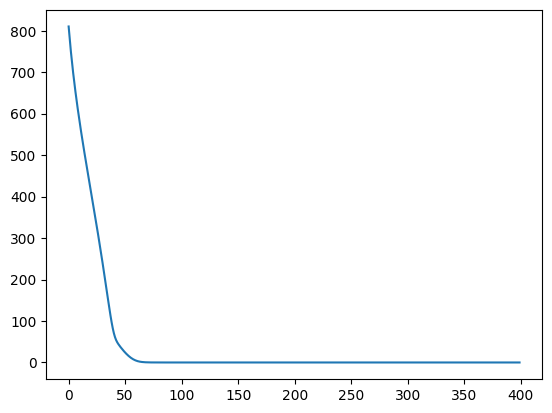

In [20]:
theta1 = torch.tensor(np.random.uniform(0, 2 * np.pi), requires_grad=True)
theta2 = torch.tensor(np.random.uniform(0, 2 * np.pi), requires_grad=True)
theta3 = torch.tensor(np.random.uniform(0, 2 * np.pi), requires_grad=True)

losses = []

draw_cake(center_point, theta1, theta2, theta3)

# optimizer = torch.optim.SGD([theta1_0, theta2_0, theta3_0], lr=0.0001)
optimizer = torch.optim.SGD([theta1, theta2, theta3], lr=0.0001)

for i in range(400):
    perim_loss = compute_loss(theta1, theta2, theta3)

    print(f'Step {i}:')
    print(f'Theta 1: {theta1}')
    print(f'Theta 2: {theta2}')
    print(f'Theta 3: {theta3}')
    print(f'Loss :{float(perim_loss.detach())}\n')

    losses += [perim_loss.detach()]

    perim_loss.backward()
    optimizer.step()
    optimizer.zero_grad(set_to_none=False)

plt.plot(losses)
plt.show()

draw_cake(center_point, theta1, theta2, theta3)